# Intro

It's the last time we meet in class for exercises! And to celebrate this mile-stone, we've put together an amazing set of exercises. And if you're behind, don't worry. The workload is low!

  - Part A: First, we play around with sentiment analysis
  - Part B **(optional)**: We study paths in networks using a fun new dataset. (If only doing part A feels too easy for you, I've added a really fun exercise that should be fun and challenging.)

But first, watch this video that touches upon your final project and Assignment 2 (which will be released later Wednesday),

> [**Video**](https://www.dropbox.com/scl/fi/jh3490oqnqh4yl629ik09/ProjectAndAssigment.mp4?rlkey=2uyl7tq0xgzydl5u8pqzncf92&dl=0) about the Independent Project and Assignment 2

# Part A: Sentiment analysis

Sentiment analysis is another highly useful technique which we'll use to make sense of the Wiki
data. Further, experience shows that it might well be very useful when you get to the project stage of the class.


> [**Video Lecture**](https://www.dropbox.com/scl/fi/u0rn767hg7e6ue4ryx41a/Sentiment.mp4?rlkey=4kwfqv6pkw1aijshm5zqe8ehh&dl=0): Sentiment and dictionary-based methods.



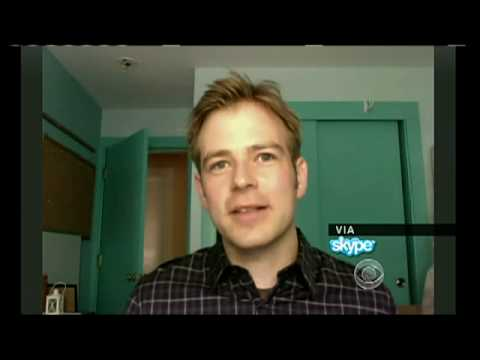

In [2]:
# There's also this one from 2010 showing Sune Lehmann on national television
from IPython.display import YouTubeVideo, HTML, display
YouTubeVideo("hY0UCD5UiiY",width=800, height=450)

> Reading: [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) 


_Exercise 1_: Sentiment distribution. 
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.
> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).
> * Iterate over the nodes in your network, tokenize each page, and calculate sentiment every single page. Now you have sentiment as a new nodal property. 
> * Remember histograms? Create a histogram of all character's associated page-sentiments. (And make it a nice histogram - use your histogram making skills from Week 2).
> * Who are the 10 rappers with happiest and saddest pages?

<!---
> * Now we average the average sentiment of the nodes in each community to find a *community level sentiment*. 
>   - Name each community by its three most connected characters. 
>   - What are the three happiest communities? 
>   - what are the three saddest communities?
>   - Do these results confirm what you can learn about each community by skimming the wikipedia pages?
--->

**Note**: Calculating sentiment takes a long time, so arm yourself with patience as your code runs (remember to check that it runs correctly, before waiting patiently). Further, these tips may speed things up. And save somewhere, so you don't have to start over.

**Tips for speed**
* If you use `freqDist` prior to finding the sentiment, you only have to find it for every unique word and hereafter you can do a weighted mean.
* More tips for speeding up loops https://wiki.python.org/moin/PythonSpeed/PerformanceTips#Loops

The LabMT wordlist was generated using Amazon's Mechanical Turk service where the annotation of the happiness level for different words was crowdsourced.

In [3]:
import numpy as np
from nltk import FreqDist
import pandas as pd

In [4]:
labMT = pd.read_csv("../files/labMT.txt", sep="\t")
labMT.set_index("word", inplace=True)
labMT.head()

,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
word,,,,,,,
laughter,1,8.50,0.9313,3600,--,--,1728
happiness,2,8.44,0.9723,1853,2458,--,1230
love,3,8.42,1.1082,25,317,328,23
happy,4,8.30,0.9949,65,1372,1313,375
laughed,5,8.26,1.1572,3334,3542,--,2332


In [5]:
rappers_df = pd.read_csv("../files/Rappers.csv")
rappers_df.set_index("WikipediaPageName", inplace=True)
rappers_df.sort_index(inplace=True)
rappers_df.head()

,Coast
WikipediaPageName,
03 Greedo,West
22Gz,East
24kGoldn,West
38 Spesh,East
40 Glocc,West


In [17]:
def sentiment(tokens):
    if(len(tokens) == 0):
        return
    freq = FreqDist(tokens)
    # get the vocabulary we can evaluate with LabMT

    vocab = list(filter(lambda word: word in labMT.index, np.unique(tokens)))
    weighted_happiness = np.fromiter((freq[word] * labMT.loc[word].happiness_average for word in vocab), dtype=float)
    word_frequencies = np.fromiter((freq[word] for word in vocab), dtype=float)
    return np.sum(weighted_happiness) / np.sum(word_frequencies)

In [21]:
import os
import string
import nltk.corpus as corpus
from nltk import word_tokenize, Text
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
# filenames = os.listdir("../files/rapper_texts")
filenames = [f"{name.replace(' ', '_')}.txt" for name in rappers_df.index]
rapper_tokens = {}
for name, file in zip(rappers_df.index, filenames):
    with open(f"../files/rapper_texts/{file}", "r") as fh:
        raw = fh.read()
        tokens = list(filter(lambda token: wnl.lemmatize(token.lower()) not in string.punctuation, word_tokenize(raw)))
        rapper_tokens[name] = tokens


In [22]:
sentiments = {}
for name in rapper_tokens.keys():
    sentiment_value = sentiment(rapper_tokens[name])
    if(sentiment_value):
        sentiments[name] = sentiment_value

In [29]:
sentiments_df = pd.DataFrame({"rapper": sentiments.keys(), "page_happiness": sentiments.values()})
sentiments_df.set_index("rapper", inplace=True)
sentiments_df.head()

,page_happiness
rapper,
03 Greedo,5.381573
22Gz,5.329292
24kGoldn,5.618791
38 Spesh,5.598146
40 Glocc,5.246625


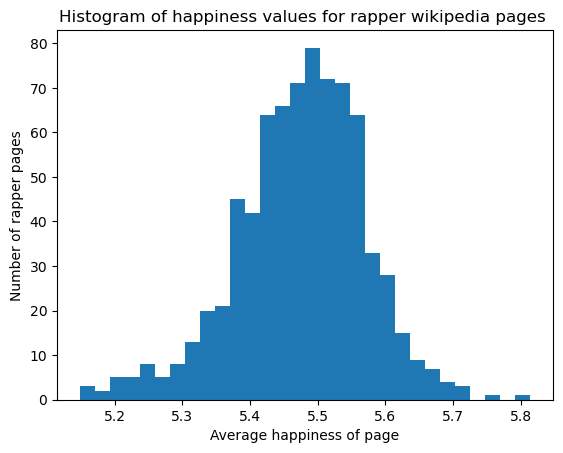

In [34]:
import matplotlib.pyplot as plt

counts, bins = np.histogram(sentiments_df.page_happiness, bins=30)
widths = bins[:-1] - bins[1:]
plt.bar(bins[:-1], counts, widths)
plt.title(label="Histogram of happiness values for rapper wikipedia pages ")
plt.xlabel(xlabel="Average happiness of page")
plt.ylabel(ylabel="Number of rapper pages")
plt.show()

In [35]:
print("Top 10 rappers with the happiest pages:")
sentiments_df.sort_values("page_happiness", ascending=False).head(10)


Top 10 rappers with the happiest pages:


,page_happiness
rapper,
Foreknown (rapper),5.825634
Theo Martins,5.779615
DJ Webstar,5.733636
D Smoke,5.723351
Blxst,5.715609
King Lil G,5.710247
MC Yogi,5.704872
Bkorn,5.704158
Bahamadia,5.703636


In [36]:
print("Top 10 rappers with the saddest pages:")
sentiments_df.sort_values("page_happiness", ascending=True).head(10)

Top 10 rappers with the saddest pages:


,page_happiness
rapper,
Cool C,5.159117
China Mac,5.162536
AR-Ab,5.180798
DJ Whoo Kid,5.200481
Benzino,5.201280
Drakeo the Ruler,5.204070
Half a Mill,5.206753
Shady Nate,5.210400
Jimmy Wopo,5.211556


*Exercise 2*: West coast and East coast.

Now, let's check if the pages of rappers from different coasts tend to have different sentiment. 

> * First, think about it for a second: Do you expect pages of rappers from different coasts to have different sentiment? Why/why not?
> * Next, Download [this file](https://github.com/SocialComplexityLab/socialgraphs2023/edit/main/files/Rappers.csv) if you do not have it already.
> * Start by plotting the distribution of sentiment for the pages of east-coast and west-coast rappers separately. 
> * Now calculate the mean, median, 10th percentile, and 90 percentile sentiment value for each coast and indicate those values on the corresponding histograms.
> * Comment on these distributions and how they relate to the overall sentiment distribution you calculated in Exercise 1 above.
> * Use the "label shuffling technique" that I illustrated in **Week 5, exercise 7** to determine whether or not 
>   1. the west-coast pages tend to have lower sentiment than a similarly sized group of randomly chosen rapper pages (pick random groups 1000 times and reject the hypothesis if 5% of the random outcomes are lower than the actual value observed for the west-coast pages)
>   2. the west-coast pages tend to have higher sentiment than a similarly sized group of randomly chosen character pages (again, use 1000 random draws and a 5% confidence bound).
>   3. (**optional**) Perhaps there are other divisions of rappers whose pages would be more likely to have different sentiment. Perhaps comparing groups of rappers of different sexes, races, etc. would give interesting results? Feel free to do a deep dive here, and let me know which groups you analyze and how you end up "guessing" a rapper's sex, race, etc. 

Comment: The "label shuffling technique" is incredibly useful. It may turn out to be a good tool to apply for your independent project. Keep it in mind.

In [45]:
east_coast_view = rappers_df[rappers_df["Coast"] == "East"]
east_coast_happiness = sentiments_df.merge(east_coast_view, how="inner", left_on="rapper", right_on="WikipediaPageName")

west_coast_view = rappers_df[rappers_df["Coast"] == "West"]
west_coast_happiness = sentiments_df.merge(west_coast_view, how="inner", left_on="rapper", right_on="WikipediaPageName")

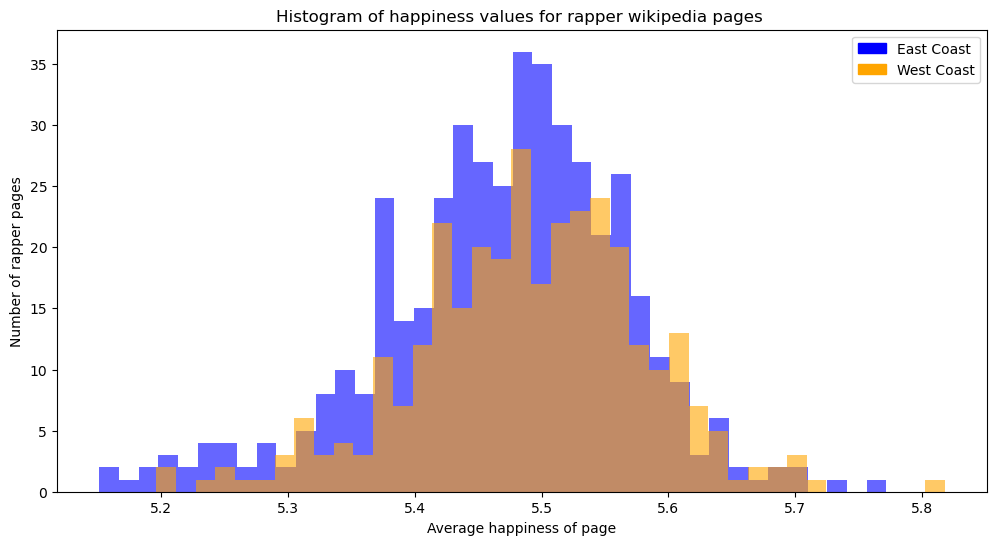

In [65]:
fig, ax = plt.subplots(figsize=(12,6))

color = ("blue", "orange")
coasts = ["East Coast", "West Coast"]
cmap = dict(zip(coasts, color))
patches = [plt.Rectangle((0,0),1,1, color=v) for k,v in cmap.items()]

for c, dataset in zip(color, [east_coast_happiness, west_coast_happiness]):
    counts, bins = np.histogram(dataset.page_happiness, bins=40)
    widths = bins[:-1] - bins[1:]
    ax.bar(bins[:-1], counts, widths, alpha=0.6, color=c)
    ax.set_title(label="Histogram of happiness values for rapper wikipedia pages ")
    ax.set_xlabel(xlabel="Average happiness of page")
    ax.set_ylabel(ylabel="Number of rapper pages")
    ax.legend(patches, coasts, loc='best')
    
plt.show()

In [63]:
for coast, dataset in zip(coasts, [east_coast_happiness, west_coast_happiness]):
    print(coast)
    print("Mean: ", dataset.page_happiness.mean())
    print("Median: ", dataset.page_happiness.median())
    print("10th percentile: ", dataset.page_happiness.quantile(0.1))
    print("90th percentile: ", dataset.page_happiness.quantile(0.9))
    print()

East Coast
Mean:  5.476893532954463
Median:  5.487142857142858
10th percentile:  5.355525347100856
90th percentile:  5.58355474148877

West Coast
Mean:  5.498938533586423
Median:  5.5007816091954025
10th percentile:  5.386234854202997
90th percentile:  5.610235294117647



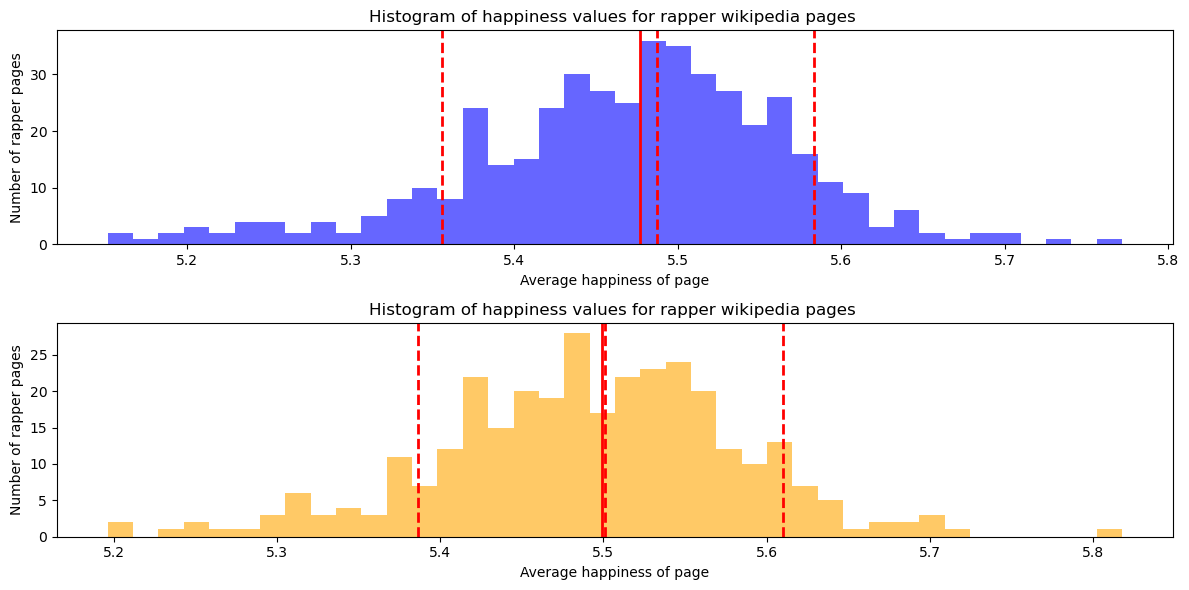

In [73]:
fig, ax = plt.subplots(2, figsize=(12,6), tight_layout=True)

color = ("blue", "orange")
coasts = ["East Coast", "West Coast"]
cmap = dict(zip(coasts, color))
patches = [plt.Rectangle((0,0),1,1, color=v) for k,v in cmap.items()]

for idx, (c, dataset) in enumerate(zip(color, [east_coast_happiness, west_coast_happiness])):
    counts, bins = np.histogram(dataset.page_happiness, bins=40)
    widths = bins[:-1] - bins[1:]
    mean = dataset.page_happiness.mean()
    median = dataset.page_happiness.median()
    p_10 = dataset.page_happiness.quantile(0.1)
    p_90 = dataset.page_happiness.quantile(0.9)
    ax[idx].bar(bins[:-1], counts, widths, color=c, alpha=0.6)
    ax[idx].set_title(label="Histogram of happiness values for rapper wikipedia pages ")
    ax[idx].set_xlabel(xlabel="Average happiness of page")
    ax[idx].set_ylabel(ylabel="Number of rapper pages")
    ax[idx].axvline(mean, color='r', linestyle='solid', linewidth=2)
    ax[idx].axvline(median, color='r', linestyle='dashed', linewidth=2)
    ax[idx].axvline(p_10, color='r', linestyle='dashed', linewidth=2)
    ax[idx].axvline(p_90, color='r', linestyle='dashed', linewidth=2)
    
plt.show()

# Part B (optional): The Wikispeedia Extravaganza

This final **AND OPTIONAL** exercise is about tying everything together. In this context "optional" means that the exercises below will not be on the assignment (but they're fun & cool).

We try to combine our work on networks plus our work on language in order to understand and analyze human behavior. We'll be working on a cool dataset of humans playing a game on (a special version of) wikipedia called "wikispeedia".  Note that the game is now called *The Wiki Game* and can be found at http://thewikigame.com/ ( ... while "http://wikispeedia.org" is a page about GPS coordinates of speed-traps). 

Here's how the game worked:

> In the game, users are asked to navigate from a given _source_ article (e.g. https://en.wikipedia.org/wiki/Gold_dollar) to a given _target_ article (e.g. https://en.wikipedia.org/wiki/Ronald_Reagan), **by only clicking Wikipedia links**. A condensed version of Wikipedia (4,604 articles) is used. 

So this dataset contains **human navigation paths** (clicking from page to page to find a target) and today we will work on this dataset to see if we can use our skills to understand how human navigation works. We will think about the following questions.

* Path lengths
* Betweenness from the human perspective
* What characterizes human paths?

Let's get started.

### Download the dataset

The first thing we're going to do is download the dataset. Today everything related to data is nice, clean, and easy to work with (Yay). You can get the dataset [here](https://snap.stanford.edu/data/wikispeedia.html). You will need to get 

* The list of wiki articles
* The network connections
* The navigation paths
* Plaintext of the wiki articles

### Path lengths

The first thing we want to take a look at is path lengths. NetworkX allows us to calculate the shortest path between any pair of articles. We begin by comparing the length of human and shortests paths. 

_Optional Exercises 1_
> * For each _source_/_target_ pair in the list of human navigation paths, calculate the shortest path using NetworkX. Plot the distribution of path lengths. Mine looks something like this (if I use an undirected graph):
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/shortest-path.png)


> * For each _source_/_target_ pair, calculate the length of the human path. The dataset contains information on people who regret a navigation step and hit the "back" button in their web-browser. It's up to you how to incorporate that information in the path. Justify your choice. Plot the distribution of human path lengths. If I ignore back steps, I get this on log-log scale:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/human-path.png)

> * How much longer are the human paths on average?
> * Create scatter plot where each point is a _source_/_target_ pair, and you have human path lengths on the $x$-axis and shortests paths on the $y$-axis.
> * Is there a correlation between human/shortest path-lengths? What is the correlation.

### Betweenness

An interesting definition of centrality is _betweenness centrality_ (here's a handy [link to the NetworkX documentation](http://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html)). In a traditional setting, this measure calculates all shortest paths in the network and then each node gets a score according to which fraction of all shortest paths pass through that node.


In this part, we will create our own version of centrality, based on the _source_/_target_ pairs in our dataset. We define a node's **navigation centrality** as follows. 

> *Navigation centrality* of node $i$ is the fraction of all navigation paths that pass through $i$. We exclude the source and target from the count. If a node has not been visited by a search, the navigation centrality of that node is defined to be zero.

In the exercises below, we investigate the relationship between navigation centrality and betweenness centrality.

*Optional Exercises 2*

> Begin by calculating the betweenness centrality and navigation centrality of all nodes in the Wikispeedia dataset.
> Note that calculating the betweenness centrality can take quite a long time, so you might start it running in a separate notebook while first estimating it based on the existing human path.
>
> * First, list the 5 pages with highest navigation centrality.
> * Second, list the 5 pages with highest betweenness centrality.
> * Compare the two lists. Explain the differences between the two lists in your own words.
> * Create a scatterplot of betweenness centrality vs. navigation centrality.
> * Let's explore the pages that have navigation centrality equal to zero.
>   * How many pages have zero navigation centrality?
>   * What is the the page with zero navigation centrality and highest betweenness centrality? Can you explain why no human navigated to this page? Can you explain why the page is central in the actual link network? (For example, you can take a look at the degree of the node).
>   * Plot the distribution of betweenness centrality for the pages with zero navigation centrality. My plot on log-log scale:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/betweenness.png)

> * Now, let's *throw out all pages with zero navigation centrality* and compare navigation- and betweenness centrality for the remaining pages.
>   * What is the correlation between betweenness centrality and navigation centrality?
>   * Comment on the top 5 outliers.

# Bringing the text into the picture

Now that we have an idea about the differences between how humans and computers search in networks, we are going to dig a little deeper using the page content to test a hypothesis to explain why the human navigation paths are longer. The general idea is that humans (who don't know about the global network structure) tend to jump between pages that have related _content_. For this reason we expect that (on average) human navigation paths have more similar content than the shortest paths in the network (which might take 'surprising' shortcuts via relatively unrelated pages). In short.

> **Hypothesis H1**: Human navigation paths have more similar content than network shortest paths.

The way we'll test this hypothesis is to first represent each page as a vector using a bag-of-words approach, then we can calculate a distance between pairs of pages using some vector-space difference, and finally we'll characterize each path by its average pair-wise distance. Below, I've set up that process as an exercise. 

*Optional Exercises 3*

> First, create a TF-IDF vector for each page. You already know all about TF-IDF from last week's exercise. The main difference is that we now _characterize **each page** by a TF-IDF vector_ and not a group of pages.
> 
> Second, write a function that calculates the distance between a pair of vectors. There are many ways to calculate distances between a pair of vectors (try a Google search for `vector space distance measures` if you want to refresh your knowledge on this topic). You're free to choose what you want, but we recommend the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).
>
> Now you're ready for the exercises
> 
> * Calculate the average pairwise similarity for all human navigation paths (the _source_/_target_ pairs from above). With start and end at node $i,j$ we can call this similarity $s_{i,j}$. Calculate mean/variance of the $s_{ij}$'s.
> * Calculate the average pairwise similarity for all shortest paths between the _source_/_target_ pairs ($S_{i,j}$). Calculate mean/variance of the $S_{i,j}$.
> * Plot the distributions of average similarities for both human- and shortest paths in a single plot. If everything works well, you should see something similar to the following:
![alt text](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/path-similarity.png)

> * Finally, for each source/target pair, compare the human-navigation average similarity with the betweenness based average similarity, testing what fraction of the time, the average similarity is lower in the case of human navigation.
> * Comment on your findings. Is **H1** true?